# Final Project- Relationship of Social Grade to Crime Rates in West Yorkshire

In [1]:
# import required packages 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
from   scipy import stats
import numpy as np
import pyproj
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs

# import the required machine learning packages
from sklearn import cluster
from sklearn.preprocessing import scale

Based on Nomis Website data for 2021 (https://www.nomisweb.co.uk/datasets/c2021sg002), various social classes will be examined according to different LSOA codes in West Yorkshire. These classes are: AB Higher and Middle Management/Executive/Professional Occupations, C1 Supervised Clerk and Junior Management/Executive/Professional Occupations, C2 Skilled Manual Occupations, and DE Semi-Skilled and Non-Skilled Manual Occupations/Unemployed and Lowest Class Occupations.

At the same time, crime records published by West Yorkshire Police in December 2021 will be reviewed (https://data.police.uk/data/). This data includes the type of crime, reporting agency, LSOA information, and location information.

In this final project, crime data and social grade data will be analyzed in detail and then the correlation between these data will be examined through LSOA codes. Afterwards, visualization will be made on the map with the K-means clustering algorithm using both data sources. These analyzes will be used to understand the relationship between crime and social grade.

# Data Summary for Crime Data


In [2]:
# The data is uploaded as a csv file, 
crime = pd.read_csv('/Users/ebrukaya/GEOGProgramming/Programmıng/Finalproject/crime.csv' ) 

In [3]:
# Data Review
crime.columns

Index(['Crime_ID', 'Month', 'Reported_by', 'Falls_within', 'Longitude',
       'Latitude', 'Location', 'LSOA_code', 'LSOA_name', 'Crime_type',
       'Last_outcome_category', 'Context'],
      dtype='object')

In [4]:
# Data Review
crime.dtypes

Crime_ID                  object
Month                     object
Reported_by               object
Falls_within              object
Longitude                float64
Latitude                 float64
Location                  object
LSOA_code                 object
LSOA_name                 object
Crime_type                object
Last_outcome_category     object
Context                  float64
dtype: object

In [5]:
# Month is a object, it is wrong
# I am going to investigate

crime['Month'].describe() # I need to change its types 

count       25793
unique          1
top       2021-12
freq        25793
Name: Month, dtype: object

In [6]:
# convert to datatime
crime['Month'] = pd.to_datetime(crime['Month'])

In [7]:
# now check the dtypes
crime.dtypes # Perfect

Crime_ID                         object
Month                    datetime64[ns]
Reported_by                      object
Falls_within                     object
Longitude                       float64
Latitude                        float64
Location                         object
LSOA_code                        object
LSOA_name                        object
Crime_type                       object
Last_outcome_category            object
Context                         float64
dtype: object

# Data Cleaning for Crime Data


In [8]:
#look for columns shape
crime.shape

(25793, 12)

In [9]:
# Check for missing data
crime.info

<bound method DataFrame.info of                                                 Crime_ID      Month  \
0      75b049e0916c2f0efa97650b30f22899249e68985deb3c... 2021-12-01   
1      9345010792bd655d5e9edc6a545cadb1d543a701b763b6... 2021-12-01   
2      2ee7ca9eafb4fc80edfc081f0a2935b96b67d3ad3d51e4... 2021-12-01   
3      1cb188942000caaa1239c7f7f11e711be3340be05c351c... 2021-12-01   
4      32248490fe12ac04831985f4c64918eca66e5f9748b589... 2021-12-01   
...                                                  ...        ...   
25788  503a967127449b6f57ee95220b57dc69b5a4b93842a72a... 2021-12-01   
25789  0957eca063cbf7550a9d4871a26b6fb05f2957bf8e2d1d... 2021-12-01   
25790  35e592355c5a578b0c07c331d1b3fe46c4f4066c101db2... 2021-12-01   
25791  b083fa200bc021766b521c47c22d5c18d48c3221935208... 2021-12-01   
25792  9ec8b960fad2d4b6cd4304f3035af82525acc376c29992... 2021-12-01   

                 Reported_by           Falls_within  Longitude   Latitude  \
0      West Yorkshire Police  West Yor

In [10]:
# Check for missing data
crime.isnull().sum()

Crime_ID                  1632
Month                        0
Reported_by                  0
Falls_within                 0
Longitude                  493
Latitude                   493
Location                     0
LSOA_code                  493
LSOA_name                  493
Crime_type                   0
Last_outcome_category     1632
Context                  25793
dtype: int64

In [11]:
# There is no information in the context column, it is deleted and redefined here
crime=crime.drop(columns =['Context'])

In [12]:
# Check the columns 
crime.columns  # yes, it doesnt contain

Index(['Crime_ID', 'Month', 'Reported_by', 'Falls_within', 'Longitude',
       'Latitude', 'Location', 'LSOA_code', 'LSOA_name', 'Crime_type',
       'Last_outcome_category'],
      dtype='object')

In [13]:
# Clean the row with null value in Crime_ID
crime2 = crime.dropna(subset=['Crime_ID'])

In [14]:
crime2.isnull().sum()

Crime_ID                   0
Month                      0
Reported_by                0
Falls_within               0
Longitude                485
Latitude                 485
Location                   0
LSOA_code                485
LSOA_name                485
Crime_type                 0
Last_outcome_category      0
dtype: int64

In [15]:
# Clean the row with null value in Longitude
crime3 = crime2.dropna(subset=['Longitude'])

In [16]:
crime3.isnull().sum()  # yes, now there is no any null row 

Crime_ID                 0
Month                    0
Reported_by              0
Falls_within             0
Longitude                0
Latitude                 0
Location                 0
LSOA_code                0
LSOA_name                0
Crime_type               0
Last_outcome_category    0
dtype: int64

# Data Exploration for Crime data

In [17]:
# How many regions(LSOA_name) are in West Yorkshire? Calculate the number of unique regions.
crime3['LSOA_name'].nunique()

7

In [18]:
# Get a list of the unique regions 
crime3['LSOA_name'].unique()

array(['Barnsley ', 'Bradford ', 'Calderdale ', 'Harrogate ', 'Kirklees ',
       'Leeds ', 'Wakefield '], dtype=object)

In [19]:
# What is the most crime LSOA Name?

crime3['LSOA_name'].value_counts()

LSOA_name
Leeds          8623
Bradford       5838
Kirklees       3702
Wakefield      3563
Calderdale     1946
Barnsley          2
Harrogate         2
Name: count, dtype: int64

In [20]:
# How many crime type are in West Yorkshire? Calculate the number of unique crime type.
crime3['Crime_type'].nunique()

13

In [21]:
# Get a list of the unique crime_types 
crime3['Crime_type'].unique()

array(['Possession of weapons', 'Drugs', 'Burglary', 'Other theft',
       'Public order', 'Violence and sexual offences',
       'Criminal damage and arson', 'Shoplifting', 'Other crime',
       'Vehicle crime', 'Robbery', 'Theft from the person',
       'Bicycle theft'], dtype=object)

In [22]:
# What is the most crime types?

crime3['Crime_type'].value_counts()

Crime_type
Violence and sexual offences    10982
Public order                     3112
Criminal damage and arson        2374
Other theft                      1663
Vehicle crime                    1242
Burglary                         1224
Shoplifting                      1143
Drugs                             653
Other crime                       508
Theft from the person             271
Robbery                           231
Possession of weapons             178
Bicycle theft                      95
Name: count, dtype: int64

In [23]:
# Which 'crime_type' are within each region?

crime3.groupby('LSOA_name')['Crime_type'].value_counts()

LSOA_name   Crime_type                  
Barnsley    Possession of weapons              1
            Drugs                              1
Bradford    Violence and sexual offences    2880
            Public order                     730
            Criminal damage and arson        609
                                            ... 
Wakefield   Drugs                             75
            Theft from the person             22
            Robbery                           22
            Possession of weapons             18
            Bicycle theft                     15
Name: count, Length: 69, dtype: int64

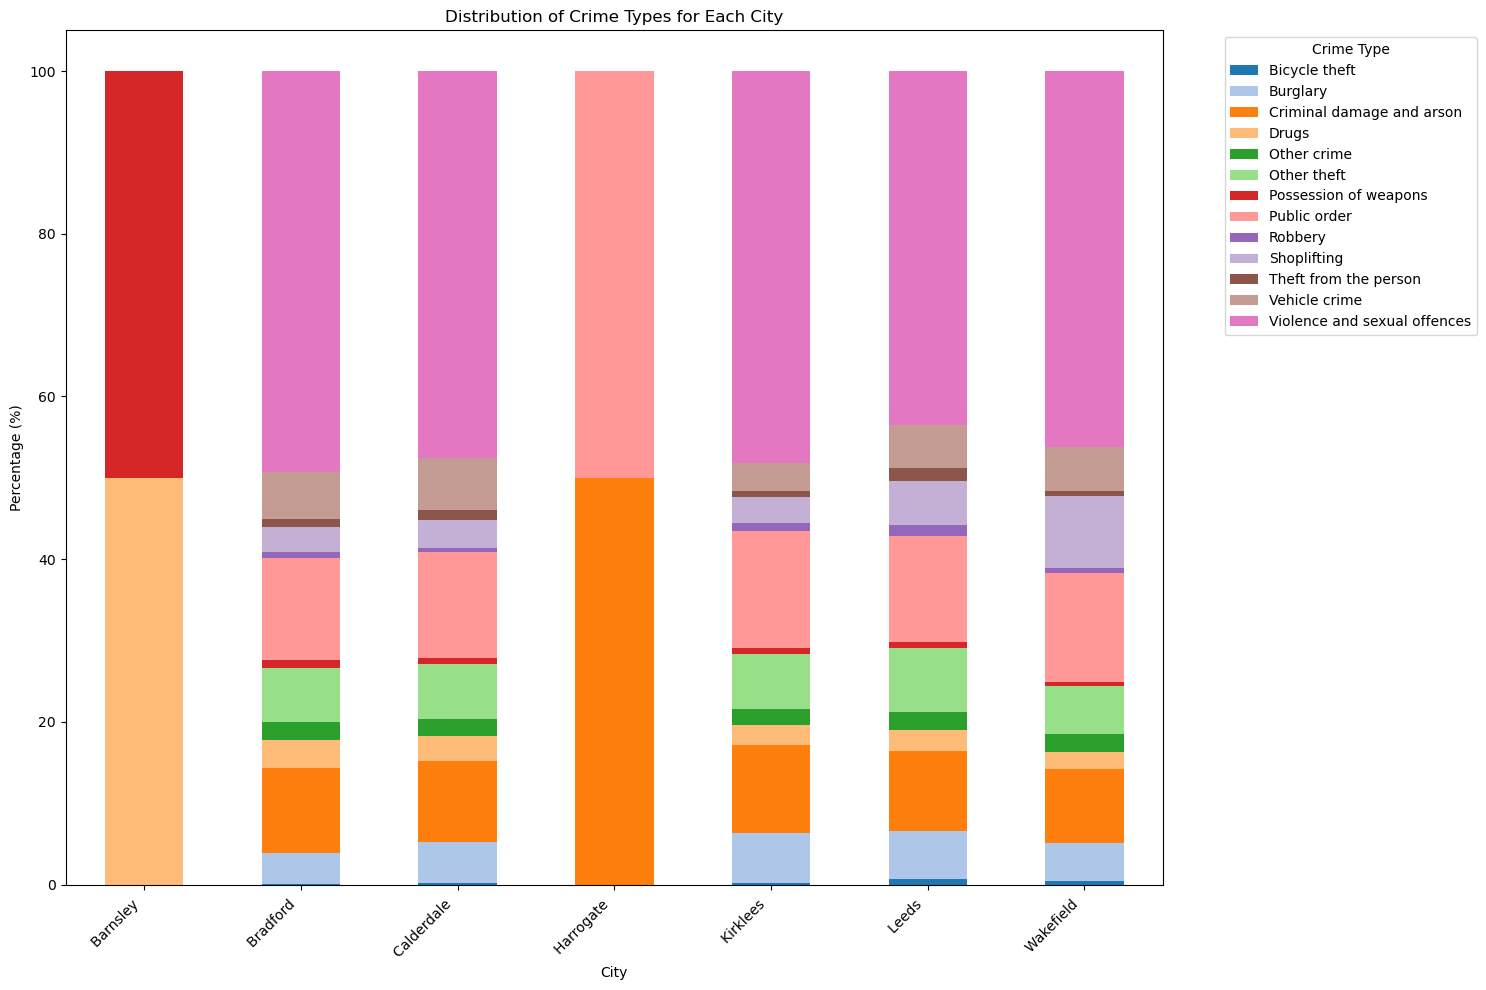

In [24]:
# Calculate the distribution of crime types for each settlement
crime_distribution = crime3.groupby(['LSOA_name', 'Crime_type']).size().unstack(fill_value=0)

# Calculate the total number of crimes for each settlement
total_crimes_per_location = crime3.groupby('LSOA_name').size()

# Calculating the percentage distribution of each type of crime for each settlement
crime_percentage_per_location = crime_distribution.div(total_crimes_per_location, axis=0) * 100

# Define a custom color palette with distinct colors
custom_palette = sns.color_palette("tab20")

# Visualation
crime_percentage_per_location.plot(kind='bar', figsize=(15, 10), stacked=True, color=custom_palette)
plt.title('Distribution of Crime Types for Each City')
plt.xlabel('City')
plt.ylabel('Percentage (%)')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


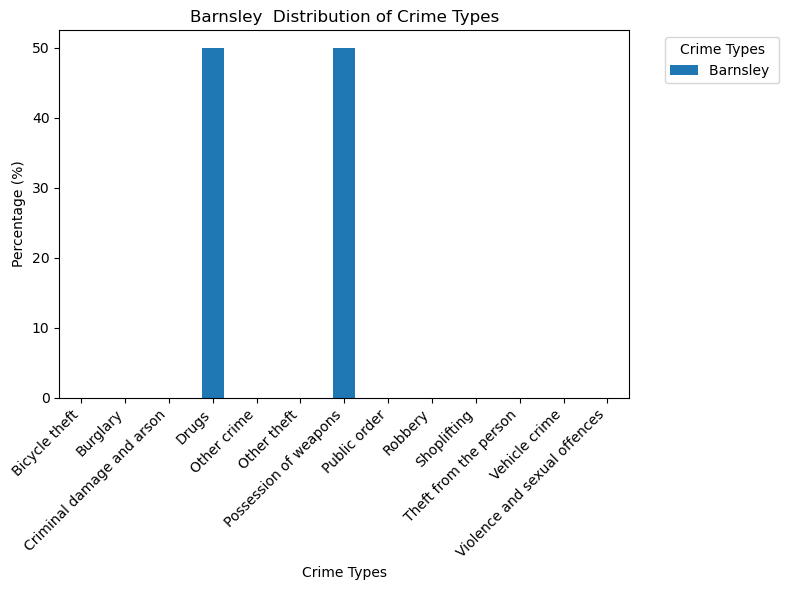

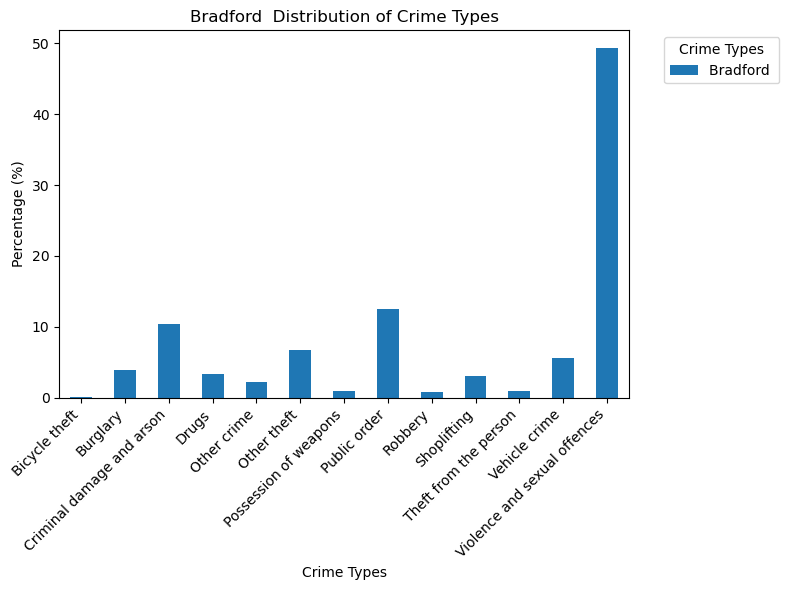

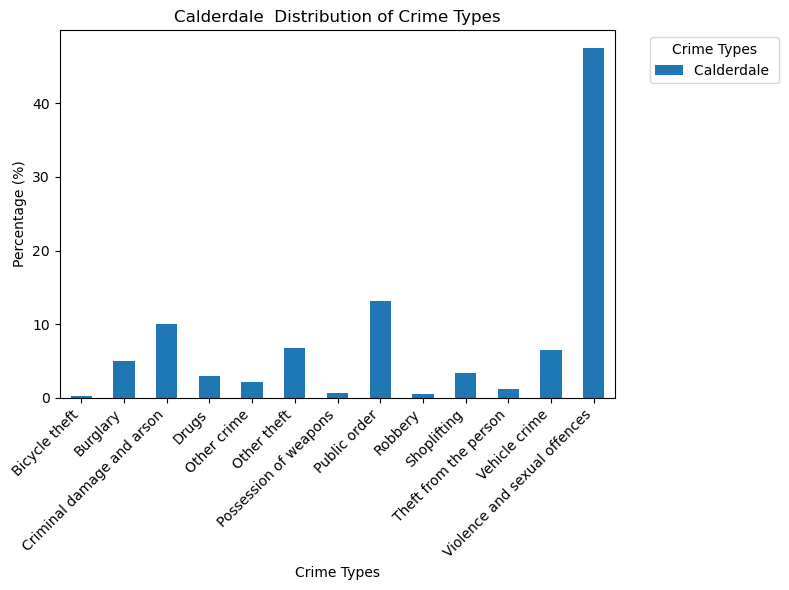

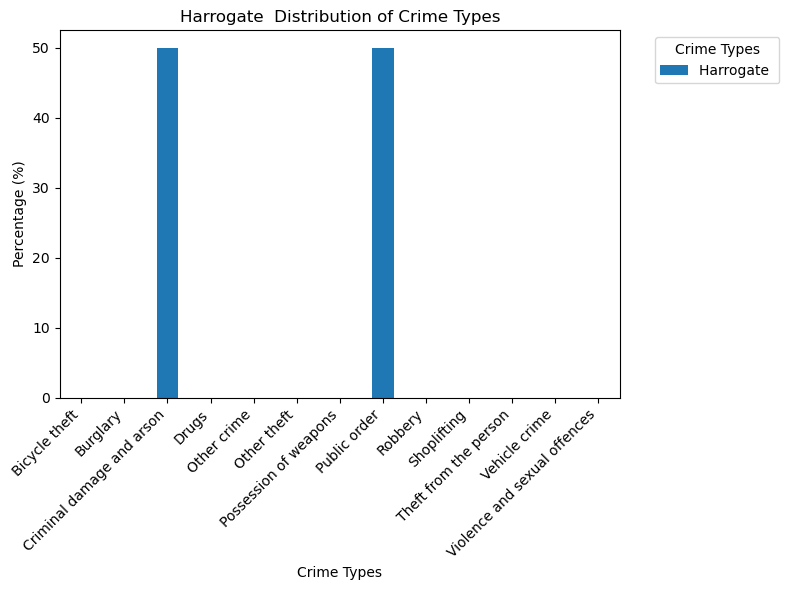

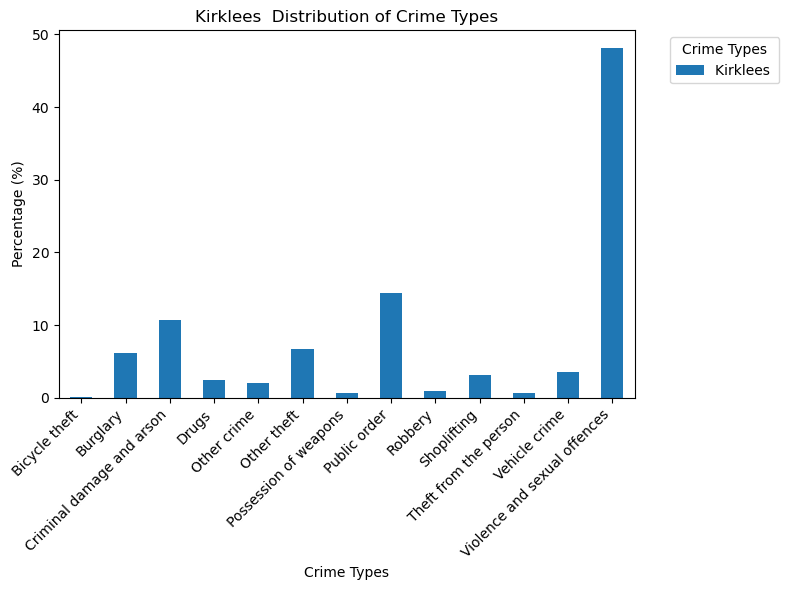

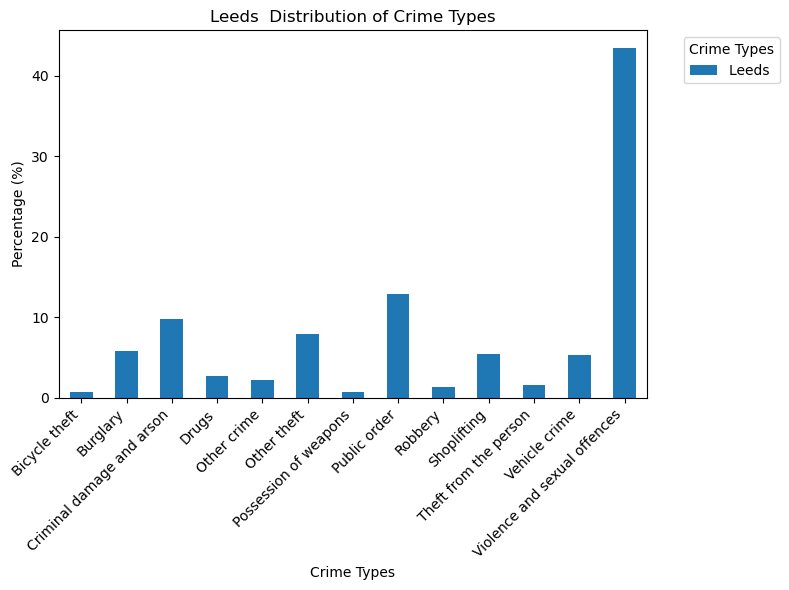

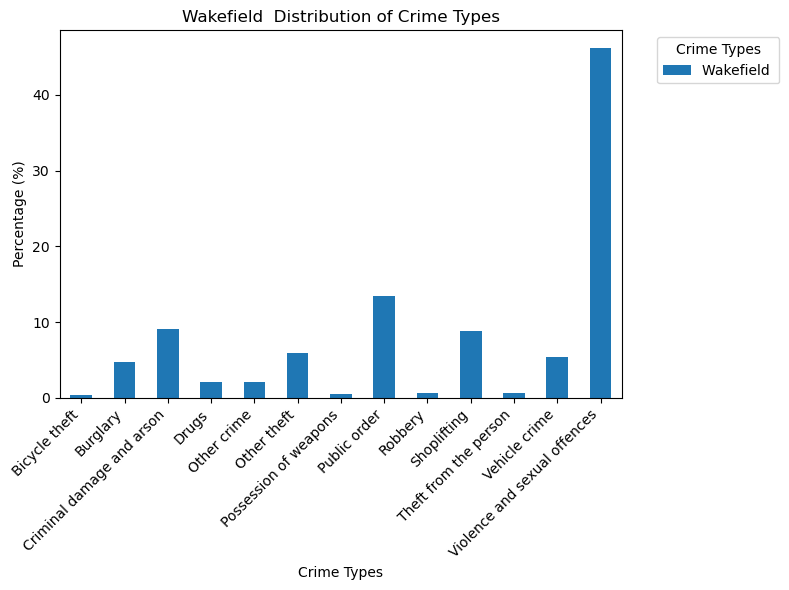

In [25]:
# Crime distribution calculation for each region separately
for location in crime_percentage_per_location.index:
    location_data = crime_percentage_per_location.loc[location]
    location_data.plot(kind='bar', figsize=(8, 6), stacked=True)
    plt.title(f'{location} Distribution of Crime Types')
    plt.xlabel('Crime Types')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Crime Types', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()

# Creating a New "crime" File by Classifying Crime Types According to LSOA Code

In [26]:
# Calculate crime counts by each LSOA code and crime type
crime_counts = crime3.groupby(['LSOA_code', 'Crime_type']).size().reset_index(name='total_crime_count')
total_crime_by_lsoa = crime_counts.groupby('LSOA_code')['total_crime_count'].sum()

# Calculate crime rates for each LSOA code
crime_counts['crime_rate'] = crime_counts.apply(lambda row: row['total_crime_count'] / total_crime_by_lsoa[row['LSOA_code']] * 100, axis=1)

# Group crime3 file by LSOA_code to include LSOA names
lsoa_names = crime3.groupby('LSOA_code')['LSOA_name'].first()

# Combine LSOA names and calculated crime counts
result = crime_counts.merge(lsoa_names, on='LSOA_code')

# Convert crime types into columns
result_pivot = result.pivot(index='LSOA_code', columns='Crime_type', values='total_crime_count')

# Fill NaN values with 0
result_pivot.fillna(0, inplace=True)

# Convert crime rates into columns
crime4 = result.pivot(index='LSOA_code', columns='Crime_type', values='crime_rate')

# Fill NaN values with 0
crime4.fillna(0, inplace=True)

# Add LSOA names
crime4['LSOA_name'] = lsoa_names.values

# Calculate the total number of crimes for each LSOA code and add the new column
crime4['total_crime_count'] = crime_counts.groupby('LSOA_code')['total_crime_count'].sum()

# Calculate the total number of crimes for each LSOA code
total_crime_by_lsoa = crime4['total_crime_count'].sum()

# Calculate the percentage of total crime rate for each LSOA and add it to a new column
crime4['total_crime_percentage_by_lsoa'] = crime4['total_crime_count'] / total_crime_by_lsoa * 100

# Result
print(crime4) # it has percentage of each crime types


Crime_type  Bicycle theft  Burglary  Criminal damage and arson  Drugs  \
LSOA_code                                                               
E01007328             0.0   0.00000                   0.000000    0.0   
E01007418             0.0   0.00000                   0.000000  100.0   
E01010568             0.0   0.00000                   0.000000    0.0   
E01010569             0.0   6.25000                  15.625000    0.0   
E01010570             0.0   0.00000                  33.333333    0.0   
...                   ...       ...                        ...    ...   
E01033697             0.0   9.52381                   0.000000    0.0   
E01034264             0.0   0.00000                   0.000000    0.0   
E01034582             0.0   0.00000                   0.000000    0.0   
E01034583             0.0   0.00000                   0.000000   50.0   
E01035046             0.0   0.00000                   0.000000    0.0   

Crime_type  Other crime  Other theft  Possession o

In [27]:
# Investigate Crime4  
crime4.dtypes # Perfect, to analyze the crime and social grade distributions of the area with each LSOA code.

Crime_type
Bicycle theft                     float64
Burglary                          float64
Criminal damage and arson         float64
Drugs                             float64
Other crime                       float64
Other theft                       float64
Possession of weapons             float64
Public order                      float64
Robbery                           float64
Shoplifting                       float64
Theft from the person             float64
Vehicle crime                     float64
Violence and sexual offences      float64
LSOA_name                          object
total_crime_count                   int64
total_crime_percentage_by_lsoa    float64
dtype: object

# Data Summary for Social Grade Data

In [28]:
# The data is uploaded as a csv file, 
social_grade = pd.read_csv('/Users/ebrukaya/GEOGProgramming/Programmıng/Finalproject/social_grade.csv' )

In [29]:
# Investigate data columns 
social_grade.columns

Index(['LSOA_code',
       'AB_Higher_and_intermediate_managerial/administrative/professional_occupations',
       'C1_Supervisory_clerical_and_junior_managerial/administrative/professional_occupations',
       'C2_Skilled_manual_occupations',
       'DE_Semi-skilled_and_unskilled_manual_occupations_unemployed_and_lowest_grade_occupations',
       'Population', 'LSOA_name'],
      dtype='object')

In [30]:
# Investigate data types 
social_grade.dtypes # Everyhing looks like perfect 

LSOA_code                                                                                   object
AB_Higher_and_intermediate_managerial/administrative/professional_occupations                int64
C1_Supervisory_clerical_and_junior_managerial/administrative/professional_occupations        int64
C2_Skilled_manual_occupations                                                                int64
DE_Semi-skilled_and_unskilled_manual_occupations_unemployed_and_lowest_grade_occupations     int64
Population                                                                                   int64
LSOA_name                                                                                   object
dtype: object

# Data Cleaning for Social Grade Data

In [31]:
# Looking for file shape
social_grade.shape

(1657, 7)

In [32]:
# Check the data
social_grade.info

<bound method DataFrame.info of       LSOA_code  \
0     E01007434   
1     E01007435   
2     E01007438   
3     E01007439   
4     E01007430   
...         ...   
1652  E01011863   
1653  E01011864   
1654  E01011866   
1655  E01011868   
1656  E01011872   

      AB_Higher_and_intermediate_managerial/administrative/professional_occupations  \
0                                                   344                               
1                                                   110                               
2                                                   159                               
3                                                   269                               
4                                                   144                               
...                                                 ...                               
1652                                                 40                               
1653                                       

In [33]:
# Check for missing data
social_grade.isnull().sum() # Everything is perfect

LSOA_code                                                                                   0
AB_Higher_and_intermediate_managerial/administrative/professional_occupations               0
C1_Supervisory_clerical_and_junior_managerial/administrative/professional_occupations       0
C2_Skilled_manual_occupations                                                               0
DE_Semi-skilled_and_unskilled_manual_occupations_unemployed_and_lowest_grade_occupations    0
Population                                                                                  0
LSOA_name                                                                                   0
dtype: int64

# Data Exploration for Social Grade Data

In [34]:
# How many regions(LSOA_name) are in data file? Calculate the number of unique regions
social_grade['LSOA_name'].nunique() # It is the same with Crime data

7

In [35]:
# Get a list of the unique regions 
social_grade['LSOA_name'].unique() # It is the same with Crime data

array(['Barnsley', 'Bradford', 'Calderdale', 'Harrogate', 'Kirklees',
       'Leeds', 'Wakefield'], dtype=object)

In [36]:
#Calculate percentage for better visualization 
social_grade['AB_percentage'] = (social_grade['AB_Higher_and_intermediate_managerial/administrative/professional_occupations'] / social_grade['Population']) * 100
social_grade['C1_percentage'] = (social_grade['C1_Supervisory_clerical_and_junior_managerial/administrative/professional_occupations'] / social_grade['Population']) * 100
social_grade['C2_percentage'] = (social_grade['C2_Skilled_manual_occupations'] / social_grade['Population']) * 100
social_grade['DE_percentage'] = (social_grade['DE_Semi-skilled_and_unskilled_manual_occupations_unemployed_and_lowest_grade_occupations'] / social_grade['Population']) * 100


In [37]:
# Check the calculation 
social_grade['AB_percentage'].head # it looks like good

<bound method NDFrame.head of 0       13.966707
1        6.828057
2       11.118881
3       18.538939
4        8.700906
          ...    
1652     2.509410
1653     2.660497
1654     8.589669
1655    10.082873
1656     4.420243
Name: AB_percentage, Length: 1657, dtype: float64>

In [38]:
# Check Percentage columns, they are added to data
social_grade.columns #Perfect

Index(['LSOA_code',
       'AB_Higher_and_intermediate_managerial/administrative/professional_occupations',
       'C1_Supervisory_clerical_and_junior_managerial/administrative/professional_occupations',
       'C2_Skilled_manual_occupations',
       'DE_Semi-skilled_and_unskilled_manual_occupations_unemployed_and_lowest_grade_occupations',
       'Population', 'LSOA_name', 'AB_percentage', 'C1_percentage',
       'C2_percentage', 'DE_percentage'],
      dtype='object')

/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/fs/jv8ldhv551xd4dzz_rvbbd9c0000gn/T/ipykernel_3472/740513843.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


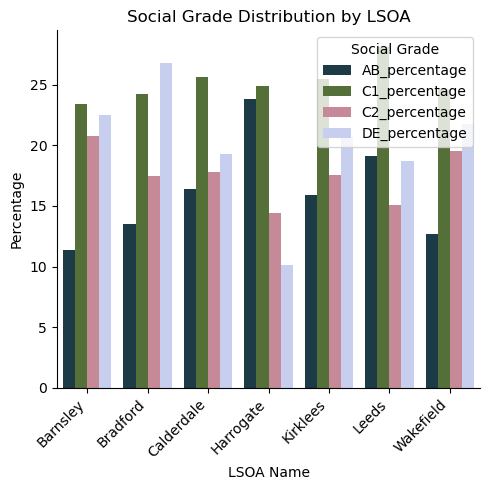

In [39]:
# Calculate average percentiles by lsoa name for each social class
mean_percentage_by_lsoa = social_grade.groupby('LSOA_name')[['AB_percentage', 'C1_percentage', 'C2_percentage', 'DE_percentage']].mean().reset_index()
# Prepare data for catplot
data = mean_percentage_by_lsoa.melt(id_vars='LSOA_name', var_name='Social Grade', value_name='Percentage')

# Create the catplot 
sns.catplot(
    x='LSOA_name',
    y='Percentage',
    hue='Social Grade',
    kind='bar',
    data=data,
    palette='cubehelix',  
    legend=False
)

# Get the legend handle from the plot (might be empty initially)
legend = plt.legend()

# If a legend exists, set its title
if legend:
    legend.set_title('Social Grade')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add title and labels
plt.xlabel('LSOA Name')
plt.ylabel('Percentage')
plt.title('Social Grade Distribution by LSOA')

plt.tight_layout()
plt.show()


# Combining Crime Data and Social Grade Data According to LSOA Code

In [40]:
# Combine crime and social grade data by LSOA code
merged_data1 = pd.merge(crime4, social_grade, on='LSOA_code', how='inner')

In [41]:
# Check data types 
merged_data1.dtypes # perfect

LSOA_code                                                                                    object
Bicycle theft                                                                               float64
Burglary                                                                                    float64
Criminal damage and arson                                                                   float64
Drugs                                                                                       float64
Other crime                                                                                 float64
Other theft                                                                                 float64
Possession of weapons                                                                       float64
Public order                                                                                float64
Robbery                                                                                     float64


In [42]:
# Check Data
merged_data1.info # this data frame has percentage of crime type and social grade

<bound method DataFrame.info of       LSOA_code  Bicycle theft  Burglary  Criminal damage and arson  Drugs  \
0     E01007328            0.0   0.00000                   0.000000    0.0   
1     E01007418            0.0   0.00000                   0.000000  100.0   
2     E01010568            0.0   0.00000                   0.000000    0.0   
3     E01010569            0.0   6.25000                  15.625000    0.0   
4     E01010570            0.0   0.00000                  33.333333    0.0   
...         ...            ...       ...                        ...    ...   
1356  E01033697            0.0   9.52381                   0.000000    0.0   
1357  E01034264            0.0   0.00000                   0.000000    0.0   
1358  E01034582            0.0   0.00000                   0.000000    0.0   
1359  E01034583            0.0   0.00000                   0.000000   50.0   
1360  E01035046            0.0   0.00000                   0.000000    0.0   

      Other crime  Other theft 

# Prepare shapefile for data visualization

The shapefile file must be loaded and made available for use. Since crime data is published on the basis of LSOA (Lower Layer Super Output Area), our shapefile containing geographical data at the LSOA level was downloaded from the Geoportal website and Census 2021 from the website. https://geoportal.statistics.gov.uk/datasets/bb427d36197443959de8a1462c8f1c55_0/explore

In [43]:
#West Yorkshire shpfile 
westyorkshire_shp =gpd.read_file('/Users/ebrukaya/GEOGProgramming/Programmıng/Finalproject/west_yorkshre_shp.shp')

In [44]:
#Check Shapefile 
westyorkshire_shp.head()

,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E01005409,Oldham 020D,402127,403557,-1.96938,53.5287,0b1d2bd5-af94-4cc3-a70b-b35ea84e583e,"MULTIPOLYGON (((406054.923 404851.569, 406033...."
1,E01005410,Oldham 006A,402031,407499,-1.97080,53.5641,924417f2-3fc9-4102-8384-bd12fb39bad2,"MULTIPOLYGON (((404974.877 406346.636, 404944...."
2,E01005414,Oldham 006C,399091,410890,-2.01520,53.5946,6be17530-b839-4f6a-86f1-76f7fde9c190,"MULTIPOLYGON (((402059.768 409617.724, 402062...."
3,E01005518,Rochdale 001A,394131,418913,-2.09030,53.6667,db54ec3c-8083-49ec-9a9a-a25ab975f07b,"MULTIPOLYGON (((396488.953 419702.706, 396486...."
4,E01005521,Rochdale 003C,395569,416007,-2.06849,53.6406,1869b9b4-a293-4333-983c-f0bb43d69bcb,"MULTIPOLYGON (((398102.058 415521.201, 398114...."


In [45]:
#Check Shapefile 
westyorkshire_shp.geometry

0       MULTIPOLYGON (((406054.923 404851.569, 406033....
1       MULTIPOLYGON (((404974.877 406346.636, 404944....
2       MULTIPOLYGON (((402059.768 409617.724, 402062....
3       MULTIPOLYGON (((396488.953 419702.706, 396486....
4       MULTIPOLYGON (((398102.058 415521.201, 398114....
                              ...                        
1452    POLYGON ((430737.415 427501.249, 430760.513 42...
1453    POLYGON ((431229.959 427511.255, 431264.502 42...
1454    POLYGON ((431312.508 427066.000, 431268.346 42...
1455    POLYGON ((432214.264 427106.239, 432235.065 42...
1456    POLYGON ((430998.545 432072.495, 430797.125 43...
Name: geometry, Length: 1457, dtype: geometry

In [46]:
#Check CRS
westyorkshire_shp.crs #perfect

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

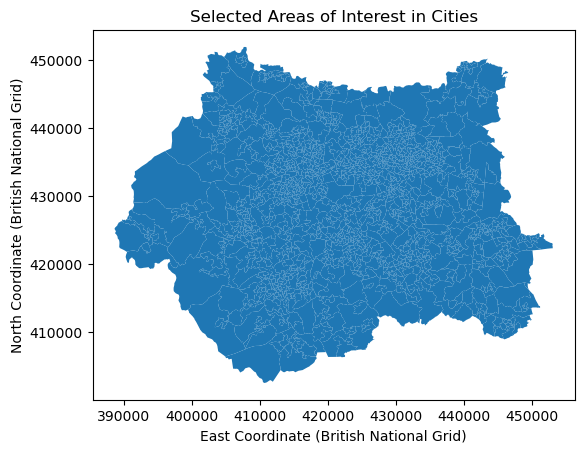

In [47]:
# We must select the city names in the crime file published by the West Yorkshire police from the shape file belonging to the West Yorkshire region.
# List of relevant cities
cities = ['Leeds', 'Bradford', 'Kirklees', 'Wakefield', 'Calderdale', 'Barnsley', 'Harrogate'] # We obtained it from the crime file

# Select and merge areas for each of the cities
selected_areas = pd.DataFrame()  

# For each city
for city in cities:
    # Select areas of the city
    city_areas = westyorkshire_shp[westyorkshire_shp['LSOA21NM'].str.contains(city) & ~westyorkshire_shp['LSOA21NM'].str.contains('_')]
    # Merge selected fields
    selected_areas = pd.concat([selected_areas, city_areas], ignore_index=True)

# Result
selected_areas.plot()
plt.title("Selected Areas of Interest in Cities")
plt.xlabel("East Coordinate (British National Grid)")
plt.ylabel("North Coordinate (British National Grid)")
plt.show()




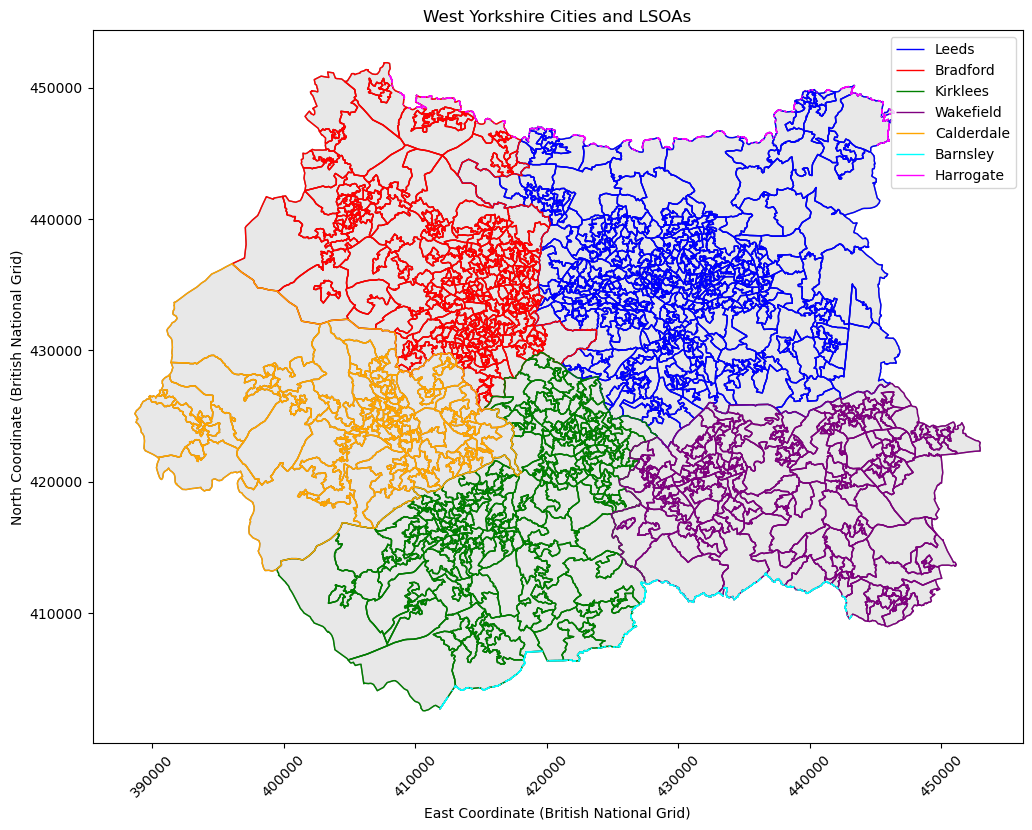

In [48]:
# List names of related cities, to select each city's border
cities = ['Leeds', 'Bradford', 'Kirklees', 'Wakefield', 'Calderdale', 'Barnsley', 'Harrogate']

# Set different colors for each city
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta']

# Select and draw relevant LSOAs for each city
fig, ax = plt.subplots(figsize=(12, 10))

for city, color in zip(cities, colors):
    # Select shapefile based on corresponding city
    city_shp = westyorkshire_shp[westyorkshire_shp['LSOA21NM'].str.contains(city) & ~westyorkshire_shp['LSOA21NM'].str.contains('_')]
    # Draw the boundaries of the city
    city_shp.boundary.plot(ax=ax, color=color, linewidth=1, label=city)
    # Draw the city's LSOAs
    city_shp.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Result
ax.tick_params(axis='x', rotation=45)
plt.title("West Yorkshire Cities and LSOAs")
plt.xlabel("East Coordinate (British National Grid)")
plt.ylabel("North Coordinate (British National Grid)")
plt.legend()
plt.show()



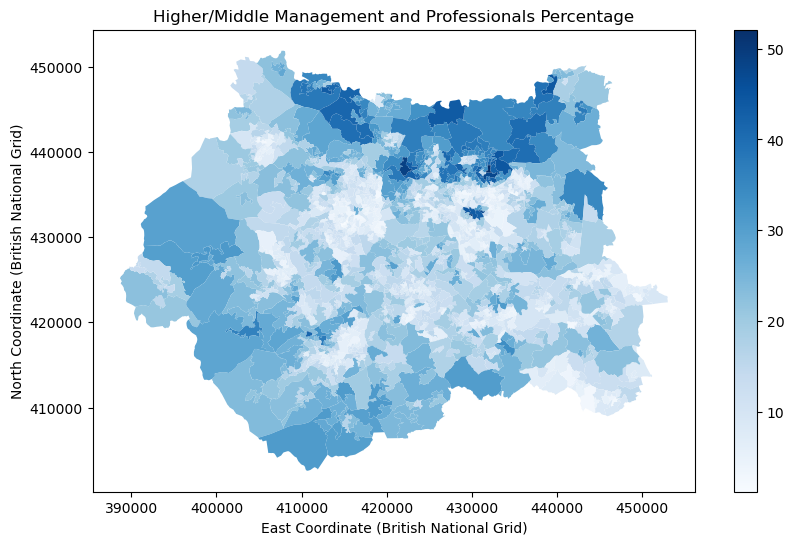

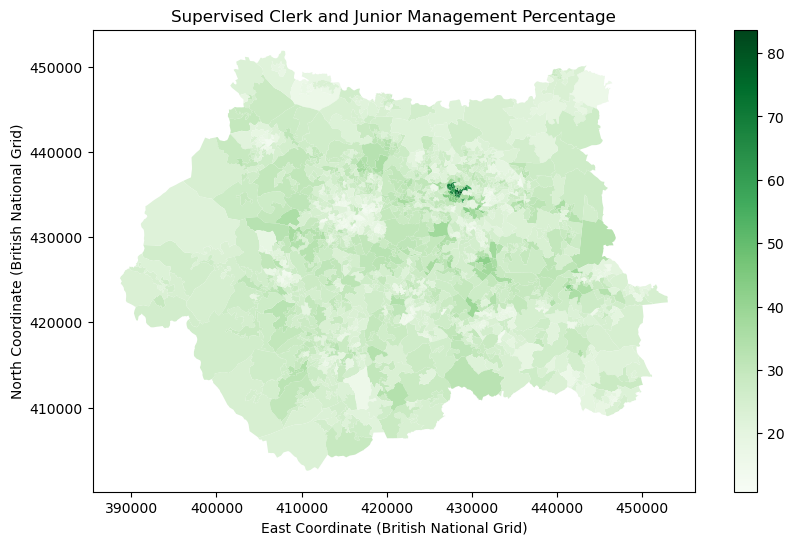

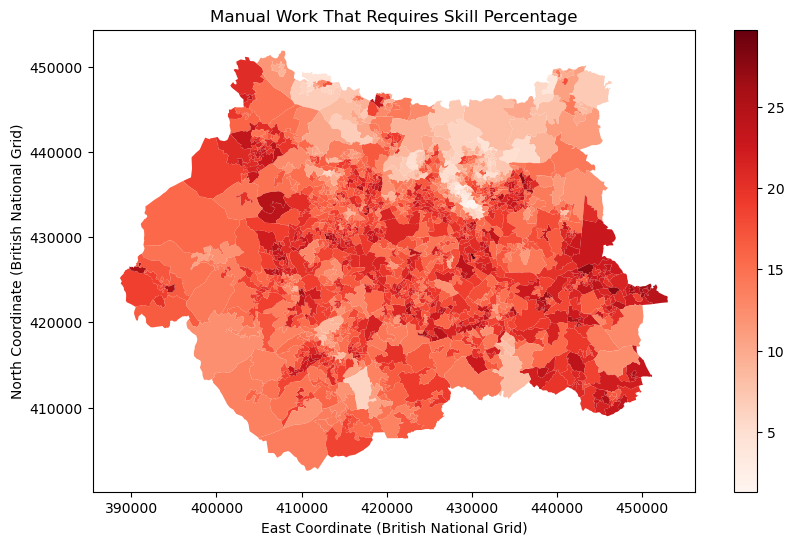

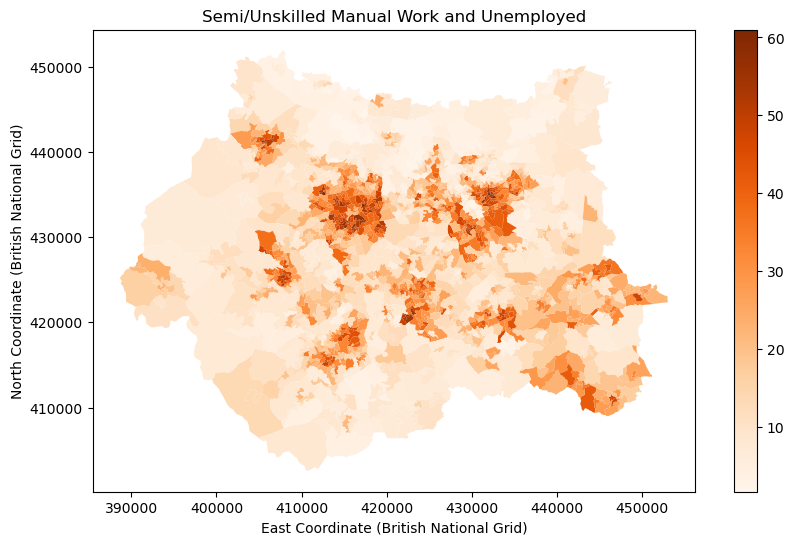

In [49]:
# Merge Shapefile and social Grade data with LSOA
merged_data2 = selected_areas.merge(social_grade, how='left', left_on='LSOA21CD', right_on='LSOA_code')

# Higher/Middle Management and Professionals Percentage Map
fig, ax = plt.subplots(figsize=(10, 6))
merged_data2.plot(column='AB_percentage', cmap='Blues', legend=True, ax=ax)
ax.set_title('Higher/Middle Management and Professionals Percentage')
plt.xlabel("East Coordinate (British National Grid)")
plt.ylabel("North Coordinate (British National Grid)")
plt.show()

# Supervised Clerk and Junior Management Percentage map 
fig, ax = plt.subplots(figsize=(10, 6))
merged_data2.plot(column='C1_percentage', cmap='Greens', legend=True, ax=ax)
ax.set_title('Supervised Clerk and Junior Management Percentage')
plt.xlabel("East Coordinate (British National Grid)")
plt.ylabel("North Coordinate (British National Grid)")
plt.show()

# Manual Work That Requires Skill Percentage map
fig, ax = plt.subplots(figsize=(10, 6))
merged_data2.plot(column='C2_percentage', cmap='Reds', legend=True, ax=ax)
ax.set_title('Manual Work That Requires Skill Percentage')
plt.xlabel("East Coordinate (British National Grid)")
plt.ylabel("North Coordinate (British National Grid)")
plt.show()

# Semi/Unskilled Manual Work and Unemployed map
fig, ax = plt.subplots(figsize=(10, 6))
merged_data2.plot(column='DE_percentage', cmap='Oranges', legend=True, ax=ax)
ax.set_title('Semi/Unskilled Manual Work and Unemployed')
plt.xlabel("East Coordinate (British National Grid)")
plt.ylabel("North Coordinate (British National Grid)")
plt.show()


All Data has been reviewed and edited. Now we move on to the spatial and non-spatial visualization step of this data.

# Non-Spatial Visulation

For non-spatial visualizations, the relationship between crime types and social grade will be analyzed with the Spearman correlation method to evaluate the relationship between them.

Spearman correlation is a statistical method used to measure the strength of the relationship between two variables, it measures the monotonic relationship between variables. A monotonic relationship refers to the tendency of a variable to be in the same direction (increasing or decreasing) as its values increase or decrease. This doesn't have to be a linear relationship; As the value of one variable increases, the values of the other variable may first increase and then decrease (U-shaped relationship) or first decrease and then increase (inverted U-shaped relationship). Spearman correlation measures such monotonic relationships, not a linear relationship (Kossowski and Hauke, 2012).

In this context, Spearman correlation can be used to understand the relationship between crime types and social grade categories. It can be thought that there is no linear relationship between crime types and social grade, and perhaps crime types or social grade tend to increase or decrease. In this case, Spearman correlation may be a suitable tool to measure such monotonic relationship.

### Explore the association between Crime and Social Grade

In [50]:
print(merged_data1.columns)


Index(['LSOA_code', 'Bicycle theft', 'Burglary', 'Criminal damage and arson',
       'Drugs', 'Other crime', 'Other theft', 'Possession of weapons',
       'Public order', 'Robbery', 'Shoplifting', 'Theft from the person',
       'Vehicle crime', 'Violence and sexual offences', 'LSOA_name_x',
       'total_crime_count', 'total_crime_percentage_by_lsoa',
       'AB_Higher_and_intermediate_managerial/administrative/professional_occupations',
       'C1_Supervisory_clerical_and_junior_managerial/administrative/professional_occupations',
       'C2_Skilled_manual_occupations',
       'DE_Semi-skilled_and_unskilled_manual_occupations_unemployed_and_lowest_grade_occupations',
       'Population', 'LSOA_name_y', 'AB_percentage', 'C1_percentage',
       'C2_percentage', 'DE_percentage'],
      dtype='object')


In [51]:
# Calculate Spearman's rank correlation
# Select crime type columns,Select social grade and total crime rate 
crime_columns = ['Bicycle theft', 'Burglary', 'Criminal damage and arson', 'Drugs',
                 'Other crime', 'Other theft', 'Possession of weapons', 'Public order',
                 'Robbery', 'Shoplifting', 'Theft from the person', 'Vehicle crime',
                 'Violence and sexual offences']

social_grade_columns = ['AB_percentage', 'C1_percentage', 'C2_percentage', 'DE_percentage']
total_crime_percentage = merged_data1['total_crime_percentage_by_lsoa']

# Merge selected columns
data_for_corr = merged_data1[crime_columns + social_grade_columns + ['total_crime_percentage_by_lsoa']]

# Calculating the correlation matrix
corr = data_for_corr.corr(method='spearman')

# Rename the social grade columns for better understanding
corr.rename(columns={'AB_percentage': 'Higher/Middle Management and Professionals',
                     'C1_percentage': 'Supervised Clerk and Junior Management',
                     'C2_percentage': 'Manual Work That Requires Skill',
                     'DE_percentage': 'Semi/Unskilled Manual Work and Unemployed'}, 
            index={'AB_percentage': 'Higher/Middle Management and Professionals',
                   'C1_percentage': 'Supervised Clerk and Junior Management',
                   'C2_percentage': 'Manual Work That Requires Skill',
                   'DE_percentage': 'Semi/Unskilled Manual Work and Unemployed'}, inplace=True)
# Rename the total crime percentage column
corr.rename(columns={'total_crime_percentage_by_lsoa': 'Total Crime Percentage by LSOA'}, 
            index={'total_crime_percentage_by_lsoa': 'Total Crime Percentage by LSOA'}, inplace=True)

corr

,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,Higher/Middle Management and Professionals,Supervised Clerk and Junior Management,Manual Work That Requires Skill,Semi/Unskilled Manual Work and Unemployed,Total Crime Percentage by LSOA
Bicycle theft,1.000000,0.062748,-0.007443,0.082946,0.055289,0.084944,0.040177,0.034301,0.079999,0.101748,0.095863,0.026743,-0.065458,-0.073745,0.006045,-0.051409,0.092620,0.185131
Burglary,0.062748,1.000000,-0.020290,-0.008922,-0.002925,-0.031791,-0.017886,-0.064398,0.028215,0.002360,0.016661,0.003959,-0.243748,0.068199,0.042695,-0.035583,-0.058220,0.072306
Criminal damage and arson,-0.007443,-0.020290,1.000000,0.017269,-0.011880,-0.073269,0.009714,-0.029291,0.031459,0.035963,-0.010882,-0.060358,-0.212003,-0.142491,-0.063563,0.112726,0.163927,0.223379
Drugs,0.082946,-0.008922,0.017269,1.000000,0.130103,0.050984,0.123237,0.042212,0.082329,0.049015,0.127977,-0.024865,-0.099946,-0.254507,-0.120523,0.092512,0.256807,0.314576
Other crime,0.055289,-0.002925,-0.011880,0.130103,1.000000,0.061290,0.069600,0.069382,0.096035,0.074073,0.021177,0.048641,-0.127080,-0.174678,-0.078510,0.112008,0.184842,0.289071
Other theft,0.084944,-0.031791,-0.073269,0.050984,0.061290,1.000000,0.073887,0.014566,0.044887,0.107105,0.100543,0.003289,-0.252838,-0.059412,-0.001534,-0.036244,0.075030,0.200029
Possession of weapons,0.040177,-0.017886,0.009714,0.123237,0.069600,0.073887,1.000000,0.050526,0.083819,0.104699,0.081883,-0.004070,-0.094402,-0.136524,-0.067738,0.033466,0.134865,0.233921
Public order,0.034301,-0.064398,-0.029291,0.042212,0.069382,0.014566,0.050526,1.000000,0.069496,0.100195,0.046603,-0.037110,-0.287961,-0.108877,-0.032071,0.053478,0.129165,0.252107
Robbery,0.079999,0.028215,0.031459,0.082329,0.096035,0.044887,0.083819,0.069496,1.000000,0.164791,0.110382,0.027082,-0.082810,-0.159665,-0.049379,0.024146,0.164289,0.276581
Shoplifting,0.101748,0.002360,0.035963,0.049015,0.074073,0.107105,0.104699,0.100195,0.164791,1.000000,0.157257,-0.033598,-0.199677,-0.067553,-0.005239,-0.017136,0.066377,0.347923


#### Visualise the Spearman's rank correlation

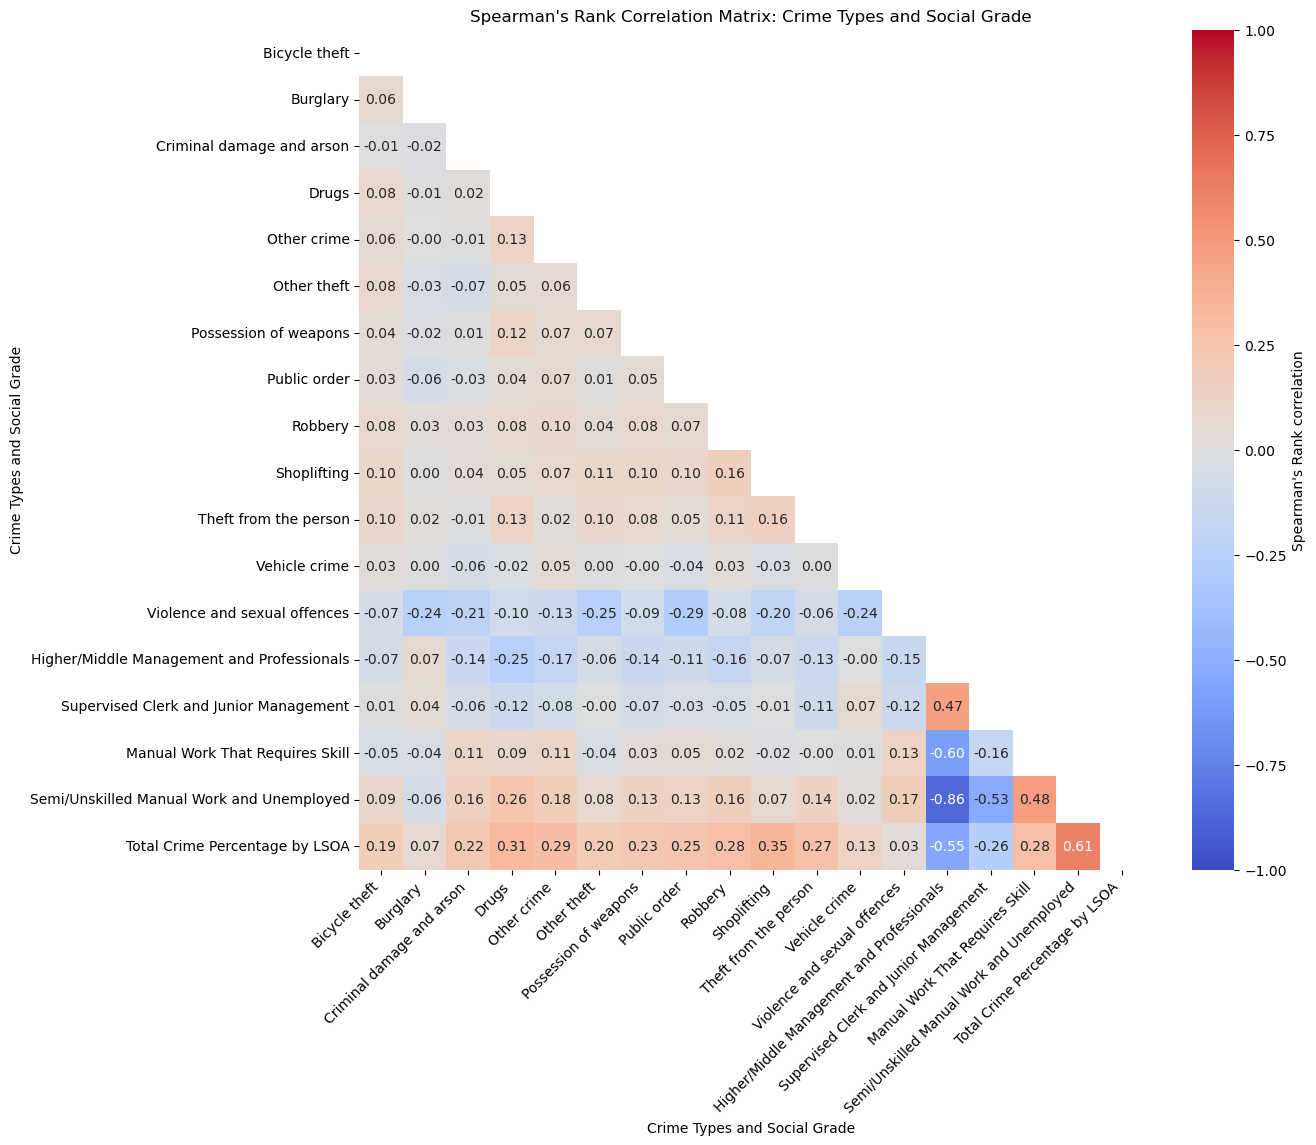

In [52]:
# define plot size
plt.figure(figsize=(14, 12))

# define mask to apply to upper right hand corner of the plot
mask = np.triu(np.ones_like(corr, dtype=bool))

#Visualize the correlation matrix and apply the mask
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, mask=mask, 
                      # Use custom labels on x and y axis
                      xticklabels=corr.columns, 
                      yticklabels=corr.index,
                      # add a label to the color bar
                      cbar_kws={'label': "Spearman's Rank correlation"})

# Plot settings
plt.title("Spearman's Rank Correlation Matrix: Crime Types and Social Grade")
plt.xlabel("Crime Types and Social Grade")  
plt.ylabel("Crime Types and Social Grade")  
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

# Result
plt.savefig('socialgrade_crimetype_Correlation.png')
plt.show()


#### Explanation 1

The Spearman correlation coefficient evaluates the relationship between two variables and can take a value between -1 and +1. If a correlation coefficient is close to +1, this indicates a positive monotonic relationship; that is, as the values of one variable increase, the values of the other variable always increase. Similarly, a correlation coefficient close to -1 indicates a strictly negative monotonic relationship; that is, as the values of one variable increase, the values of the other variable always decrease. If the correlation coefficient is close to 0, it indicates little or no relationship between the two variables (Sedgwick, 2014).


In the map created using the heat map, +1 positive relationships are represented in red and -1 negative relationships are represented in blue. Additionally, color tones provide more information about the relationship.When we examine the values, a correlation coefficient of -0.073745 between "Bicycle theft" and "Higher managerial, administrative, and professional occupations" indicates a weak negative relationship. This shows that when bicycle theft increases, the number of people working in higher-level jobs tends to decrease. Another example is the correlation coefficient of 0.314576 between “Drugs” and “Total Crime Percentage by LSOA”. This shows that as drug crimes increase, the overall crime percentage also tends to increase.

Some notable positive relationships in the table include an increase between drug crimes and overall crime percentage and an increase between theft and overall crime percentage, while negative relationships include a decrease between senior executives and overall crime percentage and a decrease between mid-level occupations and small employers.

Police departments and public policymakers need this type of analysis to improve crime-fighting strategies and reduce social inequities. We must also consider other factors that may influence crime rates, such as the socioeconomic status or demographic characteristics of the areas representing LSOAs. By carefully analyzing correlations and considering these additional factors, valuable information can be obtained about potential relationships between crime and occupational groups. These analyzes provide an important way to guide police departments and policy makers in developing crime prevention strategies and improving community safety. It is important to adopt such data-driven approaches to use resources effectively, especially in the fight against crime, and to reduce social inequalities.

# Spatial Visulation

## K-means clustering


### Identify the number of clusters using the elbow method

Elbow method is a widely used method to determine the optimal number of clusters for the k-means clustering algorithm. First, the k-means algorithm is applied for different cluster numbers and the clustering error (inertia) is calculated for each clustering. By visualizing, the "elbow point" is determined, it is the point where the number of clusters increases but the decrease in clustering error slows down, that is, the point where adding an additional cluster no longer provides a great benefit (Syakur et al., 2018). Using this method, we can determine the optimal k value for crime types. 

##### Identify the number of clusters using the elbow method for crime data

In [53]:
# Combine crime and social grade data by LSOA code
merged_data1 = pd.merge(crime4, social_grade, on='LSOA_code', how='inner') # Sometimes it gives an error so I run it again here.

/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

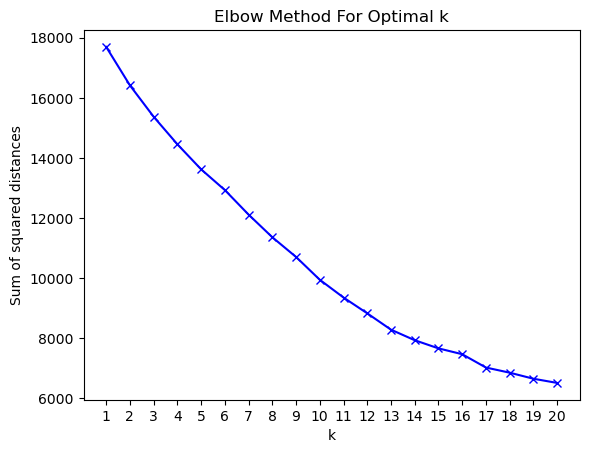

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans   # Sometimes it gives an error so I run it again here.

# Select data and scale
selected_features = ['Bicycle theft', 'Burglary', 'Criminal damage and arson', 'Drugs',
                     'Other crime', 'Other theft', 'Possession of weapons', 'Public order',
                     'Robbery', 'Shoplifting', 'Theft from the person', 'Vehicle crime',
                     'Violence and sexual offences']

X = merged_data1[selected_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determining the optimal number of clusters with the Elbow Method
Sum_of_squared_distances = []
max_clusters = 20     # Because there were so many lsoa, a high number was chosen
K = range(1, max_clusters + 1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    Sum_of_squared_distances.append(kmeans.inertia_)

# Visualition
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(1, max_clusters + 1))
plt.show()



**Elbow Method Analysis for crime data**

When we examine the graph, in the elbow method analysis performed on the crime data set, an elbow point can be seen for 4 clusters in the graph. In this case, I would argue 4 clusters would probably be best. When 4 clusters are selected, the data will be divided into four different groups and each group will be close to each other in terms of similar crime types.




### Run the K-means model with N=4 clusters for crime data

In [55]:
# Selecting and scaling data
selected_features = ['Bicycle theft', 'Burglary', 'Criminal damage and arson', 'Drugs',
                     'Other crime', 'Other theft', 'Possession of weapons', 'Public order',
                     'Robbery', 'Shoplifting', 'Theft from the person', 'Vehicle crime',
                     'Violence and sexual offences']

X = merged_data1[selected_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and apply K-Means model
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

# Get the resulting cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the data frame
merged_data1['crime_cluster'] = cluster_labels


# Result
cluster_counts = merged_data1['crime_cluster'].value_counts()
print(cluster_counts)


/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


crime_cluster
1    660
2    551
3    108
0     42
Name: count, dtype: int64


In [56]:
# Calculate the crime type distribution of each cluster
crime_cluster_distribution = merged_data1.groupby('crime_cluster')[selected_features].mean()
print(crime_cluster_distribution)

               Bicycle theft   Burglary  Criminal damage and arson     Drugs  \
crime_cluster                                                                  
0                   7.528101   7.157054                   8.892741  2.664600   
1                   0.036891   4.262364                   8.653155  1.940415   
2                   0.052212  10.191126                  12.980194  3.030288   
3                   0.061768   3.796899                   8.230263  1.176847   

               Other crime  Other theft  Possession of weapons  Public order  \
crime_cluster                                                                  
0                 1.839048     7.050030               0.608604     12.227167   
1                 1.416958     3.955337               0.469872      9.812056   
2                 3.403571    10.156596               0.826825     15.041340   
3                 1.515795     6.188775               1.568401     13.366129   

                Robbery  Shoplifting  

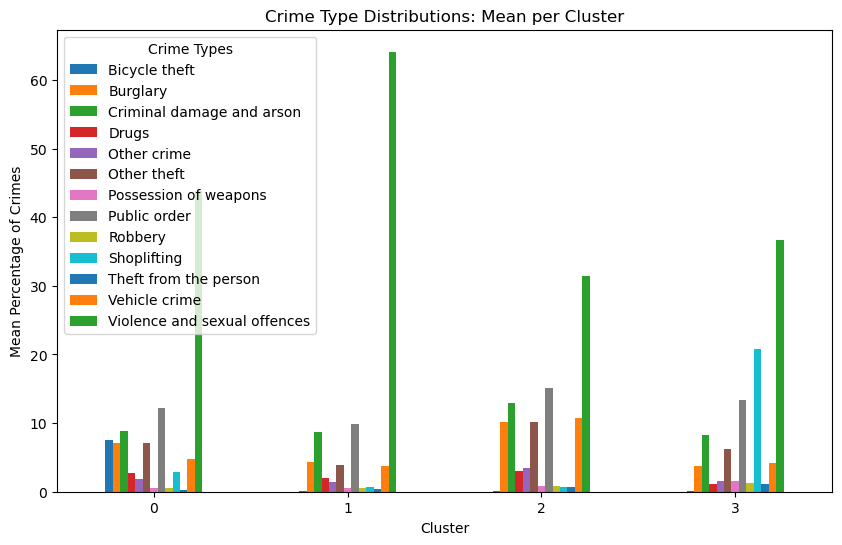

In [57]:
# Visualition for Distribution of crime cluster
crime_cluster_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Crime Type Distributions: Mean per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Percentage of Crimes')
plt.xticks(rotation=0)
plt.legend(title='Crime Types')
plt.show()

##### Identify the number of clusters using the elbow method for social grade data

/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

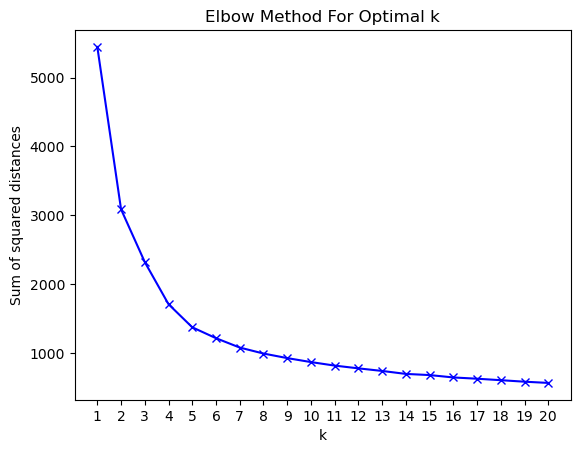

In [58]:
# Select Data
X_social_grade = merged_data1[['AB_percentage', 'C1_percentage', 'C2_percentage', 'DE_percentage']]

scaler_social_grade = StandardScaler()
X_social_grade_scaled = scaler_social_grade.fit_transform(X_social_grade)


# Determining the optimal number of clusters with the Elbow Method
Sum_of_squared_distances_social_grade = []
max_clusters_social_grade = 20
K_social_grade = range(1, max_clusters_social_grade + 1)

for k in K_social_grade:
    kmeans_social_grade = KMeans(n_clusters=k, random_state=42)
    kmeans_social_grade.fit(X_social_grade_scaled)
    Sum_of_squared_distances_social_grade.append(kmeans_social_grade.inertia_)

# Visualiton
plt.plot(K_social_grade, Sum_of_squared_distances_social_grade, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(1, max_clusters_social_grade + 1))
plt.show()



**Elbow Method Analysis for social grade**


When we examine the graph, I would argue 4 clusters would probably be best.

### Run the K-means model with N=4 clusters for social grade

In [59]:
# Select Data
selected_features = ['AB_percentage', 'C1_percentage', 'C2_percentage', 'DE_percentage']
X_social_grade = merged_data1[selected_features]
scaler_social_grade = StandardScaler()
X_social_grade_scaled = scaler_social_grade.fit_transform(X_social_grade)

# Create and apply K-Means model
kmeans_social_grade = KMeans(n_clusters=4, random_state=42)
kmeans_social_grade.fit(X_social_grade_scaled)

# Cluster labels
cluster_labels_social_grade = kmeans_social_grade.labels_

# Add cluster labels to the data frame
merged_data1['social_grade_cluster'] = cluster_labels_social_grade


# Result
cluster_counts_social_grade = merged_data1['social_grade_cluster'].value_counts()
print(cluster_counts_social_grade)


social_grade_cluster
1    561
0    431
2    355
3     14
Name: count, dtype: int64


/Users/ebrukaya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [60]:
# Calculate the crime type  Mean distribution of each cluster
social_grade_cluster_distribution = merged_data1.groupby('social_grade_cluster')[selected_features].mean()
print(social_grade_cluster_distribution)



                      AB_percentage  C1_percentage  C2_percentage  \
social_grade_cluster                                                
0                          7.174267      20.807367      19.339189   
1                         14.791817      27.745241      19.030157   
2                         28.576192      27.008497      11.586823   
3                         10.000222      69.469932       5.460379   

                      DE_percentage  
social_grade_cluster                 
0                         38.763030  
1                         17.174164  
2                          8.039702  
3                         10.028704  


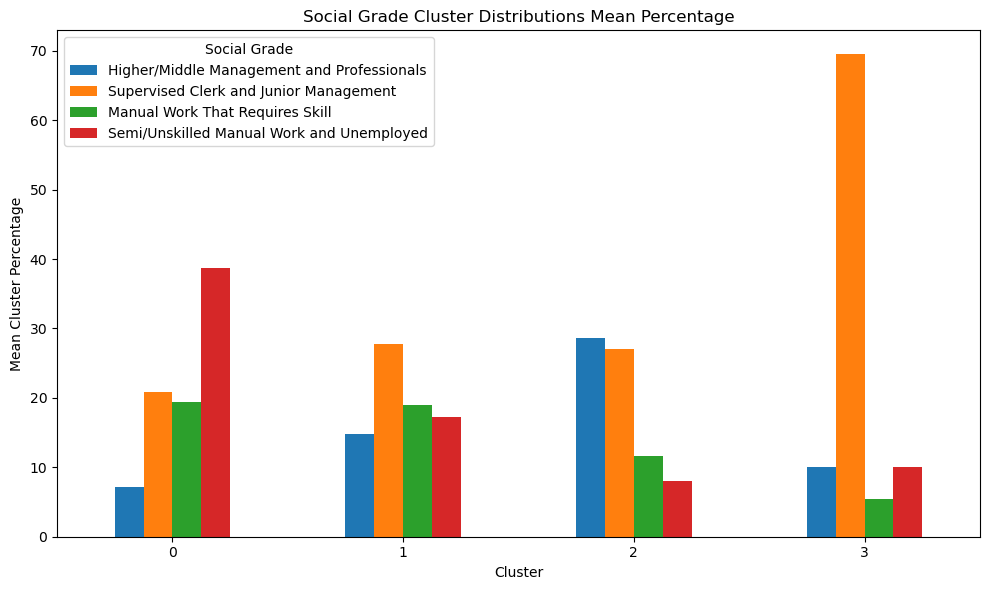

In [61]:
# Distribution of social grade cluster Mean
social_grade_cluster_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Social Grade Cluster Distributions Mean Percentage')
plt.xlabel('Cluster')
plt.ylabel('Mean Cluster Percentage')
plt.xticks(rotation=0)
plt.legend(title='Social Grade', labels=['Higher/Middle Management and Professionals', 'Supervised Clerk and Junior Management', 'Manual Work That Requires Skill', 'Semi/Unskilled Manual Work and Unemployed'])
plt.tight_layout()
plt.show()


### Combining crime k means cluster and social grade cluster

By combining data frames containing two separate clustering results, social grade and crime rates data will be associated with the same geographic areas. Thus, we will have both social grade and crime rate information for the geographical area and this information will be visualized on the map. This visualization helps us understand the relationship between social grade and crime rates in different geographical areas within the West Yorkshire region.

## Spatial Visulation

In [62]:
# Merge dataframes containing two clustering results
merged_clusters = merged_data1[['LSOA_code', 'social_grade_cluster', 'crime_cluster']]

merged_clusters

,LSOA_code,social_grade_cluster,crime_cluster
0,E01007328,0,3
1,E01007418,2,2
2,E01010568,2,2
3,E01010569,1,1
4,E01010570,2,2
...,...,...,...
1356,E01033697,0,1
1357,E01034264,0,2
1358,E01034582,1,1
1359,E01034583,2,1


#### Understanding cluster meaning

<Figure size 1000x600 with 0 Axes>

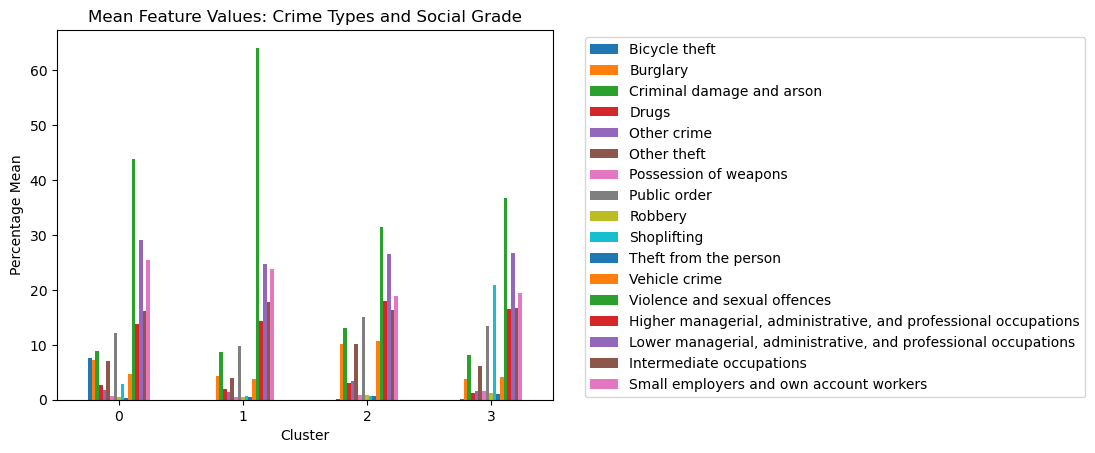

In [63]:
# Calculate the mean of each cluster's crime rate and social class characteristics
cluster_means = merged_data1.groupby('crime_cluster')[['Bicycle theft', 'Burglary', 'Criminal damage and arson', 'Drugs',
                                                      'Other crime', 'Other theft', 'Possession of weapons', 'Public order',
                                                      'Robbery', 'Shoplifting', 'Theft from the person', 'Vehicle crime',
                                                      'Violence and sexual offences', 'AB_percentage', 'C1_percentage',
                                                      'C2_percentage', 'DE_percentage']].mean()

# Label
cluster_means.rename(columns={'AB_percentage': 'Higher managerial, administrative, and professional occupations',
                              'C1_percentage': 'Lower managerial, administrative, and professional occupations',
                              'C2_percentage': 'Intermediate occupations',
                              'DE_percentage': 'Small employers and own account workers'}, inplace=True)

# Visulation
plt.figure(figsize=(10, 6))
cluster_means.plot(kind='bar')
plt.title('Mean Feature Values: Crime Types and Social Grade')
plt.xlabel('Cluster')
plt.ylabel('Percentage Mean')
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


In [64]:
# Print crime and social distribution to understand what characteristics each cluster has.
for cluster_label, row in cluster_means.iterrows():
    print(f"cluster {cluster_label}:")
    print("distribution crime:")
    for crime_type, mean_value in row[:13].items():
        print(f"{crime_type}: {mean_value:.2f}")
    print("distribution social grade:")
    for social_grade, mean_value in row[13:].items():
        print(f"{social_grade}: {mean_value:.2f}")
    print()


cluster 0:
distribution crime:
Bicycle theft: 7.53
Burglary: 7.16
Criminal damage and arson: 8.89
Drugs: 2.66
Other crime: 1.84
Other theft: 7.05
Possession of weapons: 0.61
Public order: 12.23
Robbery: 0.49
Shoplifting: 2.80
Theft from the person: 0.24
Vehicle crime: 4.73
Violence and sexual offences: 43.77
distribution social grade:
Higher managerial, administrative, and professional occupations: 13.77
Lower managerial, administrative, and professional occupations: 29.08
Intermediate occupations: 16.14
Small employers and own account workers: 25.48

cluster 1:
distribution crime:
Bicycle theft: 0.04
Burglary: 4.26
Criminal damage and arson: 8.65
Drugs: 1.94
Other crime: 1.42
Other theft: 3.96
Possession of weapons: 0.47
Public order: 9.81
Robbery: 0.47
Shoplifting: 0.73
Theft from the person: 0.44
Vehicle crime: 3.70
Violence and sexual offences: 64.11
distribution social grade:
Higher managerial, administrative, and professional occupations: 14.32
Lower managerial, administrative, a

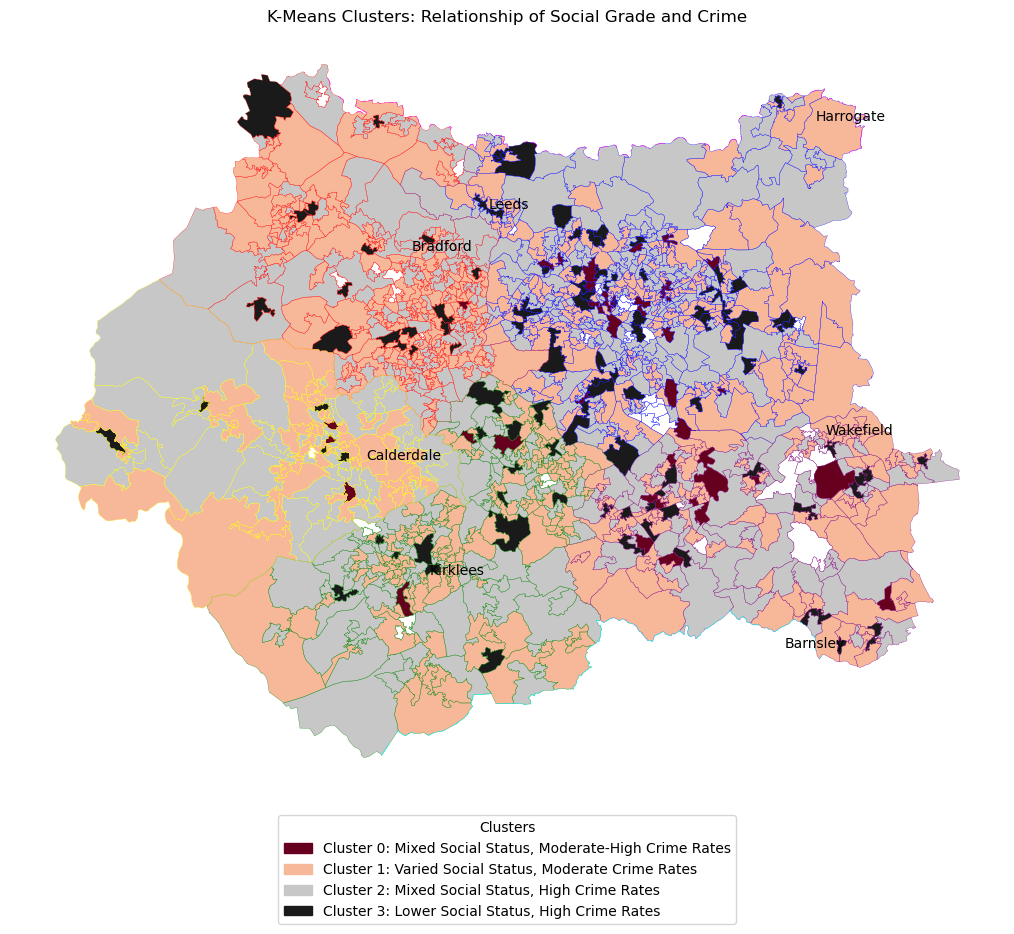

In [65]:

# Merge data matching LSOA codes
merged_shapefile = selected_areas.merge(merged_clusters, left_on='LSOA21CD', right_on='LSOA_code')

# Colors to draw city boundaries
city_colors = ['blue', 'red', 'green', 'purple', 'yellow', 'cyan', 'magenta']

# Map
fig, ax = plt.subplots(figsize=(10, 10))
merged_shapefile.plot(column='crime_cluster', categorical=True, legend=False, ax=ax, cmap='RdGy')

# Draw city boundaries and add labels
for city, color in zip(cities, city_colors):
    city_shp = selected_areas[selected_areas['LSOA21NM'].str.contains(city) & ~selected_areas['LSOA21NM'].str.contains('_')]
    city_shp.boundary.plot(ax=ax, color=color, linewidth=0.2)
    centroid = city_shp.centroid
    ax.annotate(city, (centroid.x.values[0], centroid.y.values[0]), color='black', fontsize=10, ha='center', va='center')

plt.title('K-Means Clusters: Relationship of Social Grade and Crime')

# Legend
legend_labels = {
    0: 'Cluster 0: Mixed Social Status, Moderate-High Crime Rates',
    1: 'Cluster 1: Varied Social Status, Moderate Crime Rates',
    2: 'Cluster 2: Mixed Social Status, High Crime Rates',
    3: 'Cluster 3: Lower Social Status, High Crime Rates'
}

# Creating custom legend patches
legend_handles = [mpatches.Patch(color=plt.cm.RdGy(cluster / 3), label=label) for cluster, label in legend_labels.items()]

# Position legend directly below the map
fig.legend(handles=legend_handles, title="Clusters", loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.02))

# Remove axes
plt.axis('off')

# Adjust layout to reduce space between map and legend
plt.tight_layout(pad=0.2)

plt.savefig('map.png', bbox_inches='tight')
plt.show()


### Explanation 2

This map presents a chloropleth map using the k-means clustering method to show the relationship between crime rates and social status in West Yorkshire, England. The map shows in color the different clusters distributed throughout the Lower Super Output Areas (LSOA). The legend on the right shows a color scheme, with each cluster labeled "Cluster 0" through "Cluster 3" and each cluster assigned a corresponding color.

**Cluster 0:**

There is a crime cluster prevalent in the Leeds and Wakefield areas. This cluster represents areas with varying social status and crime rates. While we focus specifically on violent and sexual crimes, significant levels of crime are also committed in other types of crime. Crimes such as public order and criminal damage also attract attention. When the social class distribution is examined, it is seen that in this cluster, especially low-level managerial, administrative and professional occupations, small employers and self-employed workers are high. This suggests that middle and lower social classes may be more prone to such crimes.

**Cluster 1:**

This cluster is scattered across West Yorkshire and represents areas of varying social status and crime rates. Although it has lower crime values than other clusters, there is still a significant crime rate in the "Violence and sexual offenses" category. The social class distribution is more balanced than the others, but the "Lower managerial, administrative, and professional occupations" category appears to be higher than the others.

**Cluster 2:**

This cluster is scattered across West Yorkshire and represents areas of varying social status and crime rates. Compared to other clusters, it has higher crime rates in crime types such as "Criminal damage and arson", "Public order" and "Vehicle crime". Social class distribution shows that, similar to other clusters, middle and lower social classes are concentrated in these types of crime.

**Cluster 3:**

There is a crime cluster concentrated in the Leeds and Bradford areas. This generally represents areas with lower social status and higher crime rates. In this cluster, shoplifting has the highest mean value in the crime type, and a significant crime rate is also found in the violent and sexual crimes category. While crimes are also seen in other types of crimes, shop theft and violent/sexual crimes stand out. Social class distribution shows that the middle and lower social classes are more concentrated in these types of crimes.

The spatial distribution of k-means cluster analysis highlights the relationship between social grade and crime rates. This information is valuable to policy makers in terms of urban planning, resource allocation and crime prevention strategies to be implemented by the police.

During the project, W3School (2024) resources were used for Python coding skills.

#### References

Kossowski, T. & Hauke, J. (2012). Analysis of the Labour Market in Metropolitan Areas: A Spatial Filtering Approach. Quaestiones Geographicae, 31(2),.

Sedgwick, P. 2014. Spearman’s rank correlation coefficient. BMJ (Online). 349, pp.g7327–g7327.


  Syakur, M.A., Khotimah, B.K., Rochman, E.M.S. and Satoto, B.D. 2018. Integration K-Means Clustering Method and Elbow Method For Identification of The Best Customer Profile Cluster. IOP Conference Series: Materials Science and Engineering. 336(1), pp.12017-.


W3Schools. (2024). Python. [Online]. [Accessed 16 May 2024]. Available from: https://www.w3schools.com/python/ May 17, 2024.

